Ноутбуки для секций с Байесовскими методами используют следующие материалы:
https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers

In [1]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as stats

Рассмотрим распределение Пуассона. Математическое ожидание СВ, распределенной по ЗР Пуассона с парметром $\lambda$ равно величине параметра.

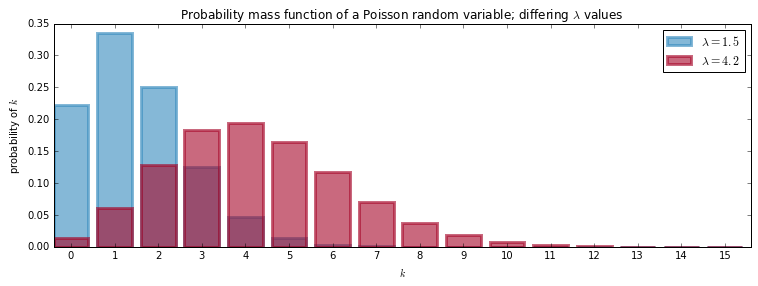

In [2]:
figsize(12.5, 4)

a = np.arange(16)
poi = stats.poisson
lambda_ = [1.5, 4.25]
colours = ["#348ABD", "#A60628"]

plt.bar(a, poi.pmf(a, lambda_[0]), color=colours[0],
        label="$\lambda = %.1f$" % lambda_[0], alpha=0.60,
        edgecolor=colours[0], lw="3")

plt.bar(a, poi.pmf(a, lambda_[1]), color=colours[1],
        label="$\lambda = %.1f$" % lambda_[1], alpha=0.60,
        edgecolor=colours[1], lw="3")

plt.xticks(a + 0.4, a)
plt.legend()
plt.ylabel("probability of $k$")
plt.xlabel("$k$")
plt.title("Probability mass function of a Poisson random variable; differing \
$\lambda$ values")

Распределение Пуассона является дискретным. В своем примере мы также расмотрим непрырывное распределение - экспоненциальное:
$$ f_X(x) = \lambda e ^{-\lambda x}.$$

Как распределение Пуассона, так и экспоненциальное распределение, принимают только неотрицательные значения. Математичекое ожидание экспоненциально распределенной СВ:
$$E(X) = \frac{1}{\lambda}.$$

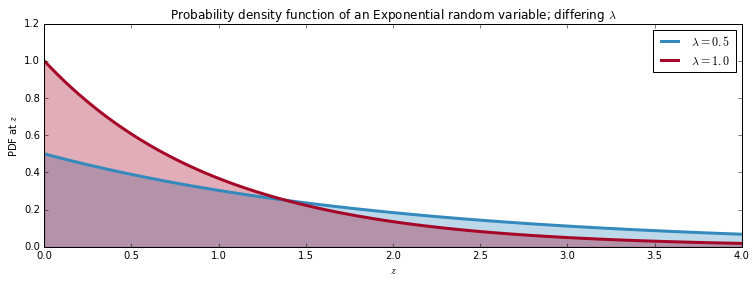

In [3]:
a = np.linspace(0, 4, 100)
expo = stats.expon
lambda_ = [0.5, 1]

for l, c in zip(lambda_, colours):
    plt.plot(a, expo.pdf(a, scale=1. / l), lw=3,
             color=c, label="$\lambda = %.1f$" % l)
    plt.fill_between(a, expo.pdf(a, scale=1. / l), color=c, alpha=.33)

plt.legend()
plt.ylabel("PDF at $z$")
plt.xlabel("$z$")
plt.ylim(0, 1.2)
plt.title("Probability density function of an Exponential random variable;\
 differing $\lambda$");

Методы оценок, которые мы рассмотрели ранее, "придерживались" следующего подхода - данные случайны, а значения параметров фиксированны. Это пример т.н. "частотного" подхода. Байесовские методы "считают" по другому - данные фиксированны, а вот значения параметров "случайны", в том смысле, что они подчиняются некоторому "априорному" распределению.

### Пример с распределением количества отправленных сообщений

Представим, что исходная задача звучит так: у нас есть число сообщений, отправленных пользователем. Можем ли оценить, менялось ли его поведение во времени и как именно?

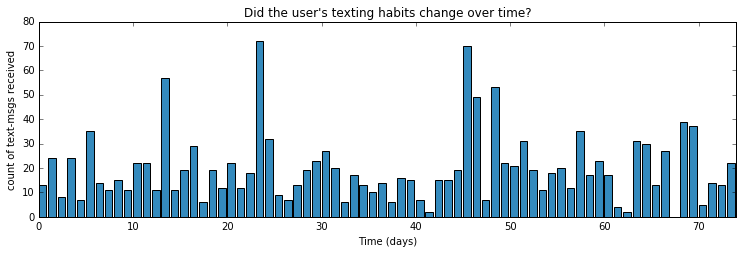

In [4]:
figsize(12.5, 3.5)
count_data = np.loadtxt("txtdata.csv")
n_count_data = len(count_data)
plt.bar(np.arange(n_count_data), count_data, color="#348ABD")
plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("Did the user's texting habits change over time?")
plt.xlim(0, n_count_data);

Будем считать, что число отправленных сообщений в каждый конкретный день подчиняется закону распределения Пуассона. 

$$C_i \sim Poisson(\lambda). $$

Пример "частотного" подхода - предположить, что число отправленных сообщений в каждый из дней - iid, оценить среднее, и найти наблюдения, сильно отстоящие от среднего, объявив их аномальными. Однако это не даст полностью ответа на исходный вопрос - был ли сдвиг именно в ежедневном поведении?

Предположим, что сдвиг имел место в момент времени $\tau$. Тогда для всех $t < \tau$ примем в качестве парметра $\lambda_1$, и $\lambda_2$ для всех моментов времени больше или равных $\tau$.

Теперь предположим, что значения $\lambda_i$ подчиненны какому-то априорному распределению, например экспоненциальному. Тогда:
$$ \lambda_i \sim EXP(\alpha_i). $$

$$ \frac{1}{n} \sum_{i=1}^{n} C_i \approx E(\lambda|\alpha) = \frac{1}{\alpha}.$$ 

Также, будем считать что $\tau$ тоже подчиняется некоторому распределению, в данном случае - равномерному на наблюдаемом трезке времени:
$$ P(\tau = k) = \frac{1}{70}.$$

Используем библиотеку для Байесовских методов pymc.

In [5]:
import pymc as pm

alpha = 1.0 / count_data.mean()  

lambda_1 = pm.Exponential("lambda_1", alpha)
lambda_2 = pm.Exponential("lambda_2", alpha)

tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data)

ImportError: No module named pymc

Инициализировав переменные, представим $\lambda$ в виде композиции 2 СВ:

In [10]:
@pm.deterministic
def lambda_(tau=tau, lambda_1=lambda_1, lambda_2=lambda_2):
    out = np.zeros(n_count_data)
    out[:tau] = lambda_1  # lambda before tau is lambda1
    out[tau:] = lambda_2  # lambda after (and including) tau is lambda2
    return out

Декоратор deterministic указывает на то, что lambda_ является детерминированной функцией от входных переменных.

In [12]:
observation = pm.Poisson("obs", lambda_, value=count_data, observed=True)
model = pm.Model([observation, lambda_1, lambda_2, tau])

 [-----------------100%-----------------] 40000 of 40000 complete in 7.0 sec

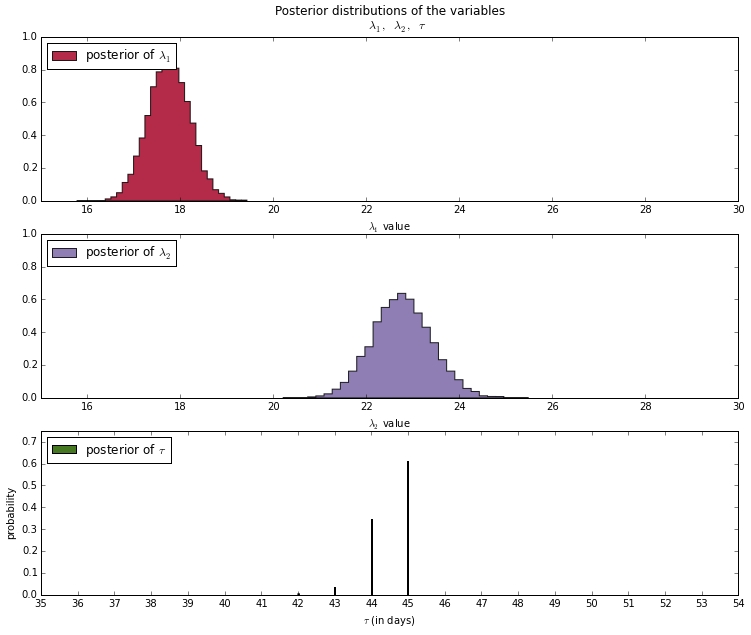

In [13]:
mcmc = pm.MCMC(model)
mcmc.sample(40000, 10000, 1)
lambda_1_samples = mcmc.trace('lambda_1')[:]
lambda_2_samples = mcmc.trace('lambda_2')[:]
tau_samples = mcmc.trace('tau')[:]
figsize(12.5, 10)
# histogram of the samples:

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([15, 30])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))

plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(count_data) - 20])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("probability");

Как можно проинтерпретировать полученные результаты?

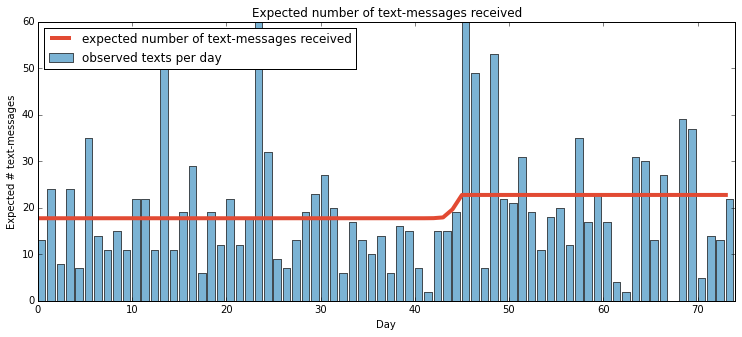

In [14]:
figsize(12.5, 5)
# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
N = tau_samples.shape[0]
expected_texts_per_day = np.zeros(n_count_data)
for day in range(0, n_count_data):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    ix = day < tau_samples
    # Each posterior sample corresponds to a value for tau.
    # for each day, that value of tau indicates whether we're "before"
    # (in the lambda1 "regime") or
    #  "after" (in the lambda2 "regime") the switchpoint.
    # by taking the posterior sample of lambda1/2 accordingly, we can average
    # over all samples to get an expected value for lambda on that day.
    # As explained, the "message count" random variable is Poisson distributed,
    # and therefore lambda (the poisson parameter) is the expected value of
    # "message count".
    expected_texts_per_day[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N


plt.plot(range(n_count_data), expected_texts_per_day, lw=4, color="#E24A33",
         label="expected number of text-messages received")
plt.xlim(0, n_count_data)
plt.xlabel("Day")
plt.ylabel("Expected # text-messages")
plt.title("Expected number of text-messages received")
plt.ylim(0, 60)
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD", alpha=0.65,
        label="observed texts per day")

plt.legend(loc="upper left");